In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
os.chdir('/content/drive/MyDrive/Colab Notebooks/NASA_Transfer_Learning/toy')
print("Current working directory: ", os.getcwd())

Current working directory:  /content/drive/MyDrive/Colab Notebooks/NASA_Transfer_Learning/toy


In [4]:
import sys

sys.path.append("/content/drive/MyDrive/Colab Notebooks/NASA_Transfer_Learning/") # Add root directory to PATH

In [5]:
from datetime import datetime
import numpy as np
import scipy.io as io

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms

from datasets import mnist, mnist_m, svhn
from models.ganin import GaninModel
import trainers.ganin as trainer
# from trainers.ganin import train_ganin, test_ganin # getting called within /toy
from utils import transform, helper


# Set random seed to ensure deterministic behavior
helper.set_random_seed(seed=123)

# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device: ", device)

Device:  cuda:0


In [6]:
# Install wandb ()

!pip install wandb --upgrade

     |████████████████████████████████| 2.1MB 5.9MB/s 
     |████████████████████████████████| 102kB 10.2MB/s 
     |████████████████████████████████| 163kB 18.6MB/s 
     |████████████████████████████████| 133kB 12.3MB/s 
     |████████████████████████████████| 71kB 8.3MB/s 
  Created wheel for subprocess32: filename=subprocess32-3.5.4-cp37-none-any.whl size=6489 sha256=ddac26a3083c2ef729787e44028f48cc8d791479ed7a7e8b6acd24a727252740
  Stored in directory: /root/.cache/pip/wheels/68/39/1a/5e402bdfdf004af1786c8b853fd92f8c4a04f22aad179654d1
  Created wheel for pathtools: filename=pathtools-0.1.2-cp37-none-any.whl size=8786 sha256=3b217c102a03638d5a9a0f4808ca4db4d59c6f9ae6cb90dbd23e76f2cf792023
  Stored in directory: /root/.cache/pip/wheels/0b/04/79/c3b0c3a0266a3cb4376da31e5bfe8bba0c489246968a68e843
Successfully built subprocess32 pathtools


In [7]:
import wandb
wandb.login()

<IPython.core.display.Javascript object>

wandb: You can find your API key in your browser here: https://wandb.ai/authorize


wandb: Paste an API key from your profile and hit enter: ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [8]:
# Hyperparameters 
config = dict(epochs=15,
              batch_size=64,
              learning_rate=2e-4,
              classes=10,
              img_size=28,
              dataset='mnist-mnist_m',
              architecture='ganin')


In [9]:
def get_data(dataset, data_dir):
    if dataset in ['mnist', 'mnist_m']:
        return torch.load(data_dir)

    elif dataset == 'svhn':
        svhn = io.loadmat(data_dir) # returns a dictionary
    
        return svhn

In [10]:
def main(hyperparameters):

    with wandb.init(project="uda-ganin-toy", config=hyperparameters, mode='disabled'):
        model = GaninModel().to(device)
        wandb.watch(model, log='all', log_freq=100)

        # transforms
        transform_tgt = transform.get_transform(dataset="mnist")
        transform_src = transform.get_transform(dataset="svhn")

        # dataloaders
        loaders_args = dict(
            batch_size=config["batch_size"],
            shuffle=True,
            num_workers=1,
            pin_memory=True,
        )

        # train_src = torch.load("../data/mnist/processed/train.pt")
        # train_src = get_data("mnist", "../data/mnist/processed/train.pt")
        train_src = get_data("svhn", "../data/svhn/train_32x32.mat")
        trainloader_src = svhn.fetch(data=train_src,
                                    transform=transform_src,
                                    **loaders_args)

        # fetching testloader_m for symmetry but it is not needed in the code
        # test_src = torch.load("../data/mnist/processed/test.pt")
        # test_src = get_data("mnist", "../data/mnist/processed/test.pt")
        test_src = get_data("svhn", "../data/svhn/test_32x32.mat")
        testloader_src = svhn.fetch(data=test_src,
                                transform=transform_src,
                                **loaders_args)

        # train_tgt = torch.load("../data/mnist_m/processed/train.pt")
        # train_tgt = get_data("svhn", "../data/svhn/train_32x32.mat")
        train_tgt = get_data("mnist", "../data/mnist/processed/train.pt")
        trainloader_tgt = mnist.fetch(data=train_tgt,
                                    transform=transform_tgt,
                                    **loaders_args)

        # test_tgt = torch.load("../data/mnist_m/processed/test.pt")
        # test_tgt = get_data("svhn", "../data/svhn/test_32x32.mat")
        test_tgt = get_data("mnist", "../data/mnist/processed/test.pt")
        testloader_tgt = mnist.fetch(data=test_tgt,
                                    transform=transform_tgt,
                                    **loaders_args)
        

        criterion_l = nn.CrossEntropyLoss() # class labels 1 to N class
        criterion_d = nn.BCEWithLogitsLoss() # domain 0/1
        optimizer = optimizer = optim.Adam(model.parameters(), lr=config["learning_rate"])
        
        start_time = datetime.now()
        for epoch in range(1, config["epochs"]+1):
            
            loss = trainer.train_ganin(model, epoch, config, trainloader_src, trainloader_tgt,
                        criterion_l, criterion_d, optimizer, device)
            
            wandb.log({"epoch" : epoch, "train_loss" : loss}, step=epoch)

            accuracy = trainer.test_ganin(model, testloader_tgt, device)

            wandb.log({"epoch" : epoch, "val_accuracy" : accuracy}, step=epoch)

        end_time = datetime.now()
        print(f"Train Time for {config['epochs']} epochs: {end_time - start_time}")

    return model


In [ ]:
# Run

output = main(config)

alpha:  0.32151273753163445


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:795: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


Epoch: 1/15 Batch: 300/1145
Total Loss: 3.2395951747894287
Epoch: 1/15 Batch: 600/1145
Total Loss: 2.834475517272949
Epoch: 1/15 Batch: 900/1145
Total Loss: 2.5882222652435303
Test accuracy: 0.03174761310219765


alpha:  0.5827829453479101
Epoch: 2/15 Batch: 300/1145
Total Loss: 1.933966875076294
Epoch: 2/15 Batch: 600/1145
Total Loss: 1.904632806777954
Epoch: 2/15 Batch: 900/1145
Total Loss: 1.877071499824524
Test accuracy: 0.03523089364171028


alpha:  0.7615941559557646


Exception in thread Thread-19:
Traceback (most recent call last):
  File "/usr/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/_utils/pin_memory.py", line 25, in _pin_memory_loop
    r = in_queue.get(timeout=MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.7/multiprocessing/queues.py", line 113, in get
    return _ForkingPickler.loads(res)
  File "/usr/local/lib/python3.7/dist-packages/torch/multiprocessing/reductions.py", line 282, in rebuild_storage_fd
    fd = df.detach()
  File "/usr/lib/python3.7/multiprocessing/resource_sharer.py", line 58, in detach
    return reduction.recv_handle(conn)
  File "/usr/lib/python3.7/multiprocessing/reduction.py", line 185, in recv_handle
    return recvfds(s, 1)[0]
  File "/usr/lib/python3.7/multiprocessing/reduction.py", line 153, in recvfds
    msg, an

KeyboardInterrupt: ignored

In [ ]:
transform_tgt = transform.get_transform(dataset="mnist")
transform_src = transform.get_transform(dataset="svhn")

# dataloaders
loaders_args = dict(
    batch_size=config["batch_size"],
    shuffle=True,
    num_workers=1,
    pin_memory=True,
)

# train_src = torch.load("../data/mnist/processed/train.pt")
# train_src = get_data("mnist", "../data/mnist/processed/train.pt")
train_src = get_data("svhn", "../data/svhn/train_32x32.mat")
trainloader_src = svhn.fetch(data=train_src,
                            transform=transform_src,
                            **loaders_args)

# fetching testloader_m for symmetry but it is not needed in the code
# test_src = torch.load("../data/mnist/processed/test.pt")
# test_src = get_data("mnist", "../data/mnist/processed/test.pt")
test_src = get_data("svhn", "../data/svhn/test_32x32.mat")
testloader_src = svhn.fetch(data=test_src,
                        transform=transform_src,
                        **loaders_args)

# train_tgt = torch.load("../data/mnist_m/processed/train.pt")
# train_tgt = get_data("svhn", "../data/svhn/train_32x32.mat")
train_tgt = get_data("mnist", "../data/mnist/processed/train.pt")
trainloader_tgt = mnist.fetch(data=train_tgt,
                            transform=transform_tgt,
                            **loaders_args)

# test_tgt = torch.load("../data/mnist_m/processed/test.pt")
# test_tgt = get_data("svhn", "../data/svhn/test_32x32.mat")
test_tgt = get_data("mnist", "../data/mnist/processed/test.pt")
testloader_tgt = mnist.fetch(data=test_tgt,
                            transform=transform_tgt,
                            **loaders_args)

In [ ]:
a = test_src
a['X'].shape

(32, 32, 3, 26032)

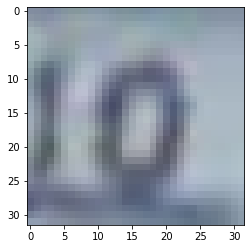

In [ ]:
import matplotlib.pyplot as plt

plt.imshow(a['X'][:,:,:,3])

In [ ]:
a['y'][:20]

array([[ 5],
       [ 2],
       [ 1],
       [10],
       [ 6],
       [ 1],
       [ 9],
       [ 1],
       [ 1],
       [ 8],
       [ 3],
       [ 6],
       [ 5],
       [ 1],
       [ 4],
       [ 4],
       [ 1],
       [ 6],
       [ 3],
       [ 4]], dtype=uint8)

In [ ]:
next(iter(testloader_tgt))[1].min()